# Design
0.3 - 25 um
everything 0 except 8-13 um

# Optimization parameters
- thickness

In [24]:
from IndexDict import IndexDict
import numpy as np
import matplotlib.pyplot as plt 
import grcwa

nm_to_um = 1e-3

dev_structure = [
    ('air',0.0*nm_to_um),
    ('sio2',230.0*nm_to_um),
    ('hfo2',485.0*nm_to_um),
    ('sio2',688.0*nm_to_um),
    ('hfo2',13.0*nm_to_um),
    ('sio2',73.0*nm_to_um),
    ('hfo2',34.0*nm_to_um),
    ('sio2',54.0*nm_to_um),
    ('ag',200.0*nm_to_um),
    ('ti',20.0*nm_to_um),
    ('si',750.0*nm_to_um),
    ('air',0.0*nm_to_um)
]
start_wv = 5  # 5 um
end_wv = 20   # 20 um
wv_sweep = np.linspace(start_wv, end_wv, num=100, endpoint=True)

IndexDict = IndexDict()

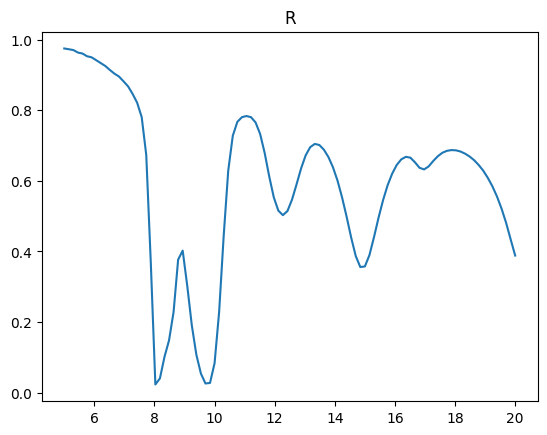

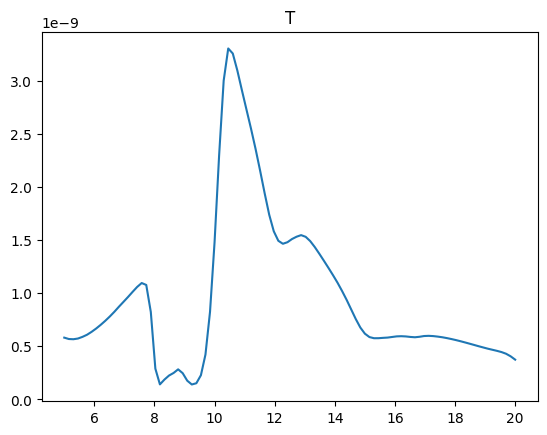

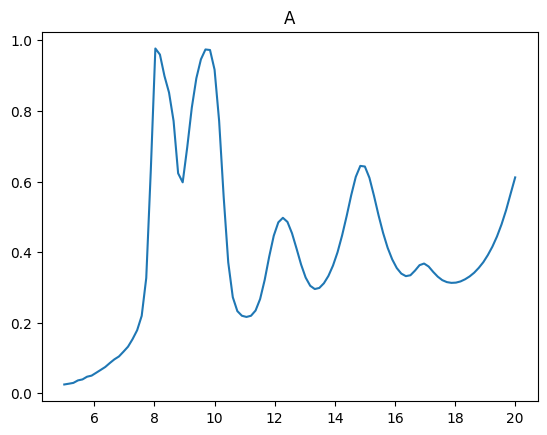

In [25]:
# grcwa

DEG_TO_RAD = np.pi / 180

# Truncation order (actual number might be smaller)
nG = 10
# lattice constants
L1 = [1,0] # 1 um
L2 = [0,1]
# frequency and angles
theta = -45 * DEG_TO_RAD
phi = 0.
# wls = np.linspace(5, 20, num=300, endpoint=True) # sweep from 5 um to 20 um
freqs = 1 / wv_sweep
Qabs = np.inf
freqcmps = freqs*(1+1j/2/Qabs)
Nx = 100
Ny = 100

Rs = np.zeros_like(freqs)
Ts = np.zeros_like(freqs)

for i in range(len(freqs)):
    ######### setting up RCWA
    obj = grcwa.obj(nG,L1,L2,freqcmps[i],theta,phi,verbose=0)
    wavelength = wv_sweep[i]
    index_dict = IndexDict.createIndexDict(['air', 'sio2', 'hfo2', 'ag', 'ti', 'si'], wavelength, '+')
    for material, thickness in dev_structure:
        obj.Add_LayerUniform(thickness, index_dict[material])

    obj.Init_Setup()

    # planewave excitation
    planewave={'p_amp':1,'s_amp':0,'p_phase':0,'s_phase':0}
    obj.MakeExcitationPlanewave(planewave['p_amp'],planewave['p_phase'],planewave['s_amp'],planewave['s_phase'],order = 0)

    # compute reflection and transmission
    R,T= obj.RT_Solve(normalize=1)
    # print('R=',R,', T=',T,', R+T=',R+T)
    Rs[i] = np.real(R)
    Ts[i] = np.real(T)

plt.plot(wv_sweep, Rs)
plt.title('R')
plt.show()

plt.plot(wv_sweep, Ts)
plt.title('T')
plt.show()

As = 1 - Rs - Ts
plt.plot(wv_sweep, As)
plt.title('A')
plt.show()

Text(0.5, 1.0, 'A')

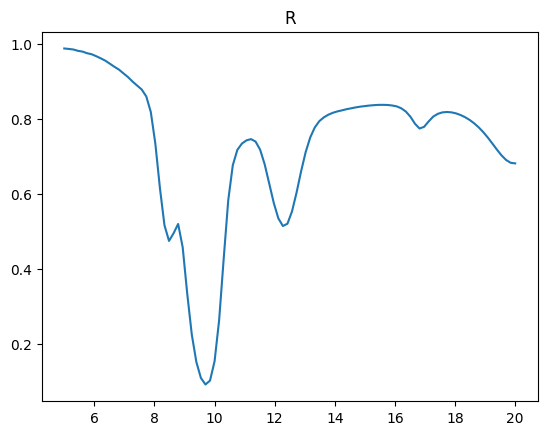

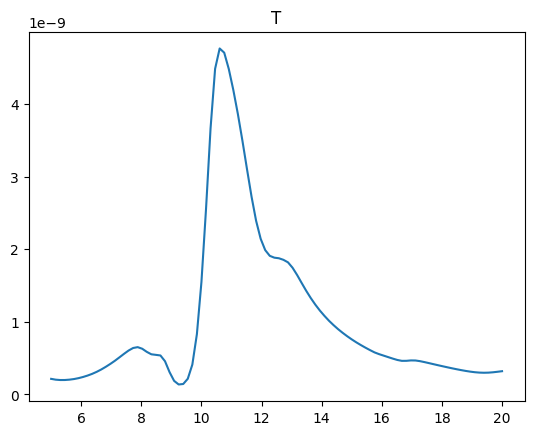

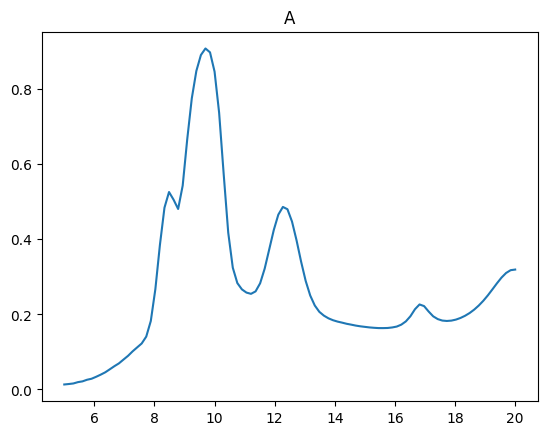

In [26]:
# Transfer matrix https://github.com/sbyrnes321/tmm

from tmm import coh_tmm
import matplotlib.pyplot as plt 

R_list = []
T_list = []

sio2_nk = []

for wavelength in wv_sweep:
    n_list = []
    index_dict = IndexDict.createIndexDict(['air', 'sio2', 'hfo2', 'ag', 'ti', 'si'], wavelength, '+')
    # sio2_nk.append(np.sqrt(index_dict['sio2']))
    # index_dict = {'air': 1, 'sio2': 1.5 + 1j}
    for material, thickness in dev_structure:
        n_list.append(np.sqrt(index_dict[material]))

    d_list = [thickness for material, thickness in dev_structure]
    d_list[0] = np.inf
    d_list[-1] = np.inf

    res = coh_tmm('s', n_list, d_list, 0, wavelength)
    R_list.append(res['R'])
    T_list.append(res['T'])

plt.figure()
plt.plot(wv_sweep,R_list)
plt.title('R')

plt.figure()
plt.plot(wv_sweep,T_list)
plt.title('T')

A_list = [1 - T_list[i] - R_list[i] for i in range(len(T_list))]
plt.figure()
plt.plot(wv_sweep, A_list)
plt.title('A')

# plt.figure()
# plt.plot(wv_sweep,[nk.real for nk in sio2_nk])
# plt.title('N')

# plt.figure()
# plt.plot(wv_sweep,[nk.imag for nk in sio2_nk])
# plt.title('K')